$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\given}[]{~\middle\vert~}
$$

# CS236605: Deep Learning
# Tutorial 8: Geometric deep learning

## Introduction

In this tutorial, we will cover:

TODO

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'running on: {device}')

running on: cpu


## Theory Reminders: Non-euclidean domains

## Part 1: Semi-supervised node classification

We'll now face the problem of classifying nodes in a small social-network graph, where we only have true labels for a tiny subset of the nodes.

The approach is roughly based on [Kipf & Welling (2016)](http://arxiv.org/abs/1609.02907).

### Dataset

We'll use a toy dataset of a small social network represented as a graph, known as "Zachary's Karate Club" (Zachary, W. W., J. Anthr. R., 1977).

The network has two **communities** which we'll try to detect, by classifying each node as belonging to one of them.

From [Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club),

> A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.
> The network captures 34 members of a karate club, documenting links between pairs of members who **interacted outside the club**.
>
> During the study a conflict arose between the **administrator** "John A" and **instructor** "Mr. Hi" (pseudonyms), which led to the split of the club into two.
> 
> Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. 
> 

In [10]:
# NetworkX is a very useful graph library for python
import networkx as nx

G = nx.karate_club_graph()
ID_INSTR = 0
ID_ADMIN = 33
ID_MEMBERS = set(G.nodes()) - {ID_ADMIN, ID_INSTR}

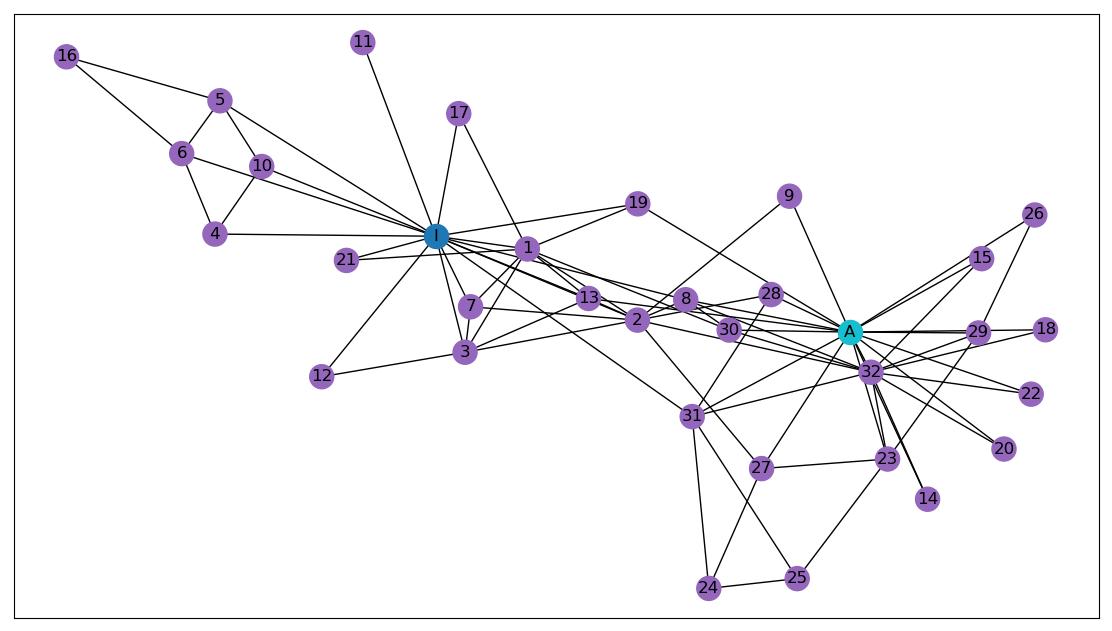

In [11]:
# Visualize the Karate Club graph
fig, ax = plt.subplots(1,1, figsize=(14,8), dpi=100)
pos = nx.spring_layout(G)
cmap = dict(cmap=plt.cm.tab10, vmin=0, vmax=1)
nx.draw_networkx_nodes(G, pos, nodelist=[ID_INSTR], node_color=(0.,), ax=ax, **cmap)
nx.draw_networkx_nodes(G, pos, nodelist=[ID_ADMIN], node_color=(1.,), ax=ax, **cmap)
nx.draw_networkx_nodes(G, pos, nodelist=ID_MEMBERS, node_color=(0.4,)*len(ID_MEMBERS), ax=ax, **cmap)
nx.draw_networkx_edges(G, pos)
node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','I'])})
nx.draw_networkx_labels(G, pos, labels=node_labels, ax=ax);

#### Features and targets

- Each node in the graph has an extra attribute, `club`, representing the member's post-split affiliation.
- We'll save all the labels for test time, but we'll only train on the Instructor and Administrator data.
- Instead of real features for each node (member) we'll just use a one-hot encoding.
  The purpose is to show that we can classify nodes based on the graph structure alone.

In [12]:
# Input: features will be one-hot vectors (no actual info conveyed)
X = torch.eye(G.number_of_nodes())

# Create ground-truth labels
labels = [(0 if d['club']=='Mr. Hi' else 1) for i,d in G.nodes().data()]
labels = torch.tensor(labels, dtype=torch.long)

# Labels represent group affiliation
list(G.nodes().data())

[(0, {'club': 'Mr. Hi'}),
 (1, {'club': 'Mr. Hi'}),
 (2, {'club': 'Mr. Hi'}),
 (3, {'club': 'Mr. Hi'}),
 (4, {'club': 'Mr. Hi'}),
 (5, {'club': 'Mr. Hi'}),
 (6, {'club': 'Mr. Hi'}),
 (7, {'club': 'Mr. Hi'}),
 (8, {'club': 'Mr. Hi'}),
 (9, {'club': 'Officer'}),
 (10, {'club': 'Mr. Hi'}),
 (11, {'club': 'Mr. Hi'}),
 (12, {'club': 'Mr. Hi'}),
 (13, {'club': 'Mr. Hi'}),
 (14, {'club': 'Officer'}),
 (15, {'club': 'Officer'}),
 (16, {'club': 'Mr. Hi'}),
 (17, {'club': 'Mr. Hi'}),
 (18, {'club': 'Officer'}),
 (19, {'club': 'Mr. Hi'}),
 (20, {'club': 'Officer'}),
 (21, {'club': 'Mr. Hi'}),
 (22, {'club': 'Officer'}),
 (23, {'club': 'Officer'}),
 (24, {'club': 'Officer'}),
 (25, {'club': 'Officer'}),
 (26, {'club': 'Officer'}),
 (27, {'club': 'Officer'}),
 (28, {'club': 'Officer'}),
 (29, {'club': 'Officer'}),
 (30, {'club': 'Officer'}),
 (31, {'club': 'Officer'}),
 (32, {'club': 'Officer'}),
 (33, {'club': 'Officer'})]

#### Graph laplacian

We'll calculate a modified version of the normalized graph Laplacian based on the paper,

$$
\mat{\Delta} = \mat{D}^{-1/2}\tilde{\mat{A}}\mat{D}^{-1/2}.
$$

Where $\tilde{\mat{A}}=\mat{A}+\mat{I}$, $\mat{A}$ is the adjacency matrix and $\mat{D}=\mathrm{diag}(\{\sum_{i} \tilde{A}_{i,j}\})$ is the degree matrix.

Note that,

$$
\Delta_{ij} = \frac{\tilde{A}_{ij}}{\sqrt{D_{ii} D_{jj}}}.
$$

Specifically, $\tilde{\mat{A}}$ represents a graph with self-loops.

**What's the significance of self-loops in our model?**

This allows the output features of a node to depend on it's input features, not just on it's neighbors.

For example, at layer $l$,

$$
\mat{Z}^{l} = \varphi( \mat{\Delta} \mat{Z}^{l-1} \mat{W}^l )
$$

**What do each of these matrix operation represent?**

- $\mat{\Delta} \mat{Z}^{l-1}$ is **combining** input feature maps, locally: from each node and it's neighbors.
- $\mat{W}^l$ is **transforming** the combined features to an output feature map.

In [96]:
# Adjacency matrix
A = nx.adj_matrix(G, weight=None)
A = np.array(A.todense())
I = np.eye(A.shape[0])
A = A + I

# Degree matrix
dii = np.sum(A, axis=1, keepdims=False)
D = np.diag(dii)

# Normalized Laplacian
D_inv_h = np.diag(dii**(-0.5))
L = np.matmul(D_inv_h, np.matmul(A, D_inv_h))

### Model

We'll implement our graph convolutional network (GCN) directly based on the **spatial** formula shown above.

I.e., we'll compute simple powers of the Laplacian matrix to locally combine node features.

Our model will have two GCN layers.
Each layer takes a tensor containing $C_\text{in}$ features for each node,
and returns a tensor containing $C_\text{out}$ features.

<img src="img/gcn.png" width="900" />


In [97]:
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, graph_L, in_features, out_features, max_deg=1):
        super().__init__()
        self.graph_L = graph_L
        
        self.fc_layers = []
        for i in range(max_deg):
            fc = nn.Linear(in_features, out_features, bias=(i==max_deg-1))
            self.add_module(f'fc_{i}', fc)
            self.fc_layers.append(fc)
        
    def forward(self, X):
        Z = torch.tensor(0.)
        L = self.graph_L
        
        for fc in self.fc_layers:
            LX = torch.mm(L, X)
            Z = fc(LX) + Z
            L = torch.mm(L, self.graph_L)
        
        return torch.relu(Z)

Note that this is a naïve and computationally inefficient implementation.

In [98]:
torch.manual_seed(44)

in_features, out_features = X.shape[1], 2
graph_L = torch.tensor(L, dtype=torch.float)
max_deg = 2
hidden_dim = 10

# Stack two GCN layers as our model
gcn2 = nn.Sequential(
    GCNLayer(graph_L, in_features, hidden_dim, max_deg),
    GCNLayer(graph_L, hidden_dim, out_features, max_deg),
    nn.LogSoftmax(dim=1)
)
gcn2

Sequential(
  (0): GCNLayer(
    (fc_0): Linear(in_features=34, out_features=10, bias=False)
    (fc_1): Linear(in_features=34, out_features=10, bias=True)
  )
  (1): GCNLayer(
    (fc_0): Linear(in_features=10, out_features=2, bias=False)
    (fc_1): Linear(in_features=10, out_features=2, bias=True)
  )
  (2): LogSoftmax()
)

### Training

We'll train as a simple classification task, with the only nuance that only the Instructor and Administrator labels are used.

In [99]:
import torch.nn.functional as F
import torch.optim

optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.01)

y_pred_epochs = []
for epoch in range(60+1):
    y_pred = gcn2(X)
    y_pred_epochs.append(y_pred.detach())
    
    # Semi-supervised: only use labels of the Instructor and Admin nodes
    labelled_idx = [ID_ADMIN, ID_INSTR]
    loss = F.nll_loss(y_pred[labelled_idx], labels[labelled_idx])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:2d}, loss={loss.item():.5f}')

Epoch  0, loss=0.69509
Epoch 10, loss=0.51789
Epoch 20, loss=0.29285
Epoch 30, loss=0.10795
Epoch 40, loss=0.03433
Epoch 50, loss=0.01383
Epoch 60, loss=0.00758


Since our loss is calculated based on two samples only, it's not a good criterion of overall classification accuracy.

Let's look at the the accuracy over all nodes:

In [100]:
from sklearn.metrics import classification_report

y_pred = torch.argmax(gcn2(X), dim=1).numpy()
y = labels.numpy()

print(classification_report(y, y_pred, target_names=['I','A']))

              precision    recall  f1-score   support

           I       1.00      0.94      0.97        17
           A       0.94      1.00      0.97        17

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



### Visualization

In [103]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_classification(G, y_pred_epochs):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    
    def draw(epoch_idx):
        pos = {}
        colors = []
        for v in range(G.number_of_nodes()):
            pos[v] = y_pred_epochs[epoch_idx][v].numpy()
            y_pred_v = np.argmax(pos[v])
            y_v = labels[v]
            if y_pred_v == y_v: colors.append(y_v)
            else: colors.append(0.5) # wrong prediction
            
        ax.cla()
        ax.set_xlabel('log p(class 1)')
        ax.set_ylabel('log p(class 2)')
        ax.set_title(f'Epoch {epoch_idx}')

        nx.draw_networkx(G, pos, node_color=colors, with_labels=False, ax=ax, **cmap)
        nx.draw_networkx_labels(G, pos, labels=node_labels, ax=ax);

    anim = animation.FuncAnimation(fig, draw, frames=len(y_pred_epochs), interval=100)
    html = HTML(anim.to_html5_video())
    plt.close()
    
    return html

In [104]:
animate_classification(G, y_pred_epochs)

## Part 2: Message-passing GCN

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Kipf T, Welling M. Semi-Supervised Classification with Graph Convolutional Networks (2016).